In [1]:
from IPython.display import clear_output
from keras import models, optimizers, losses
from keras import backend as K
from keras.utils import Progbar
from utils import *
from network import *
from matplotlib import pyplot as plt
import cv2

Using TensorFlow backend.


In [2]:
def plot_fn(pred, label):
#     if mode != 'test':
        
    plt.figure(figsize=(16, 16))
    for i in range(12):
        plt.subplot(4, 6, i+1)
        plt.xlabel("%f"%(pred[0,...,i].max()))
        plt.imshow(pred[0,...,i], cmap='gray', vmin = 0, vmax = label.max())
        plt.subplot(4, 6, i+1+12)
        plt.title("%f"%(label[0,...,i].max()))
        plt.imshow(label[0,...,i], cmap='gray', vmin = 0, vmax = label.max())
    plt.show()

In [3]:
G = generator(model='dense', n_slice=12, case=2)

print("\n===================================\n")

D = discriminator(model='dense', n_slice=12, case=1)

=========== Information about Backbone ===========
Loading DenseNet121 model
Total Parameter of Model :  7,037,504
Trainable Parameter of Model :  6,953,856
Non-Trainable Parameter of Model :  83,648

=========== Information about Whole Network ===========
Total Parameter of Model :  25,883,916
Trainable Parameter of Model :  25,800,268
Non-Trainable Parameter of Model :  83,648


=========== Information about Backbone ===========
Loading DenseNet121 model


C:\Users\user\Anaconda3\lib\site-packages\keras_applications\imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 12 input channels.
  str(input_shape[-1]) + ' input channels.')


Total Parameter of Model :  7,065,728
Trainable Parameter of Model :  6,982,080
Non-Trainable Parameter of Model :  83,648

=========== Information about Whole Network ===========
Total Parameter of Model :  16,504,961
Trainable Parameter of Model :  16,421,313
Non-Trainable Parameter of Model :  83,648


In [4]:
def Gen2Dis(gen, dis, case=1):
    if case==2:
        dis_out, texture = dis(gen.output)
        net = models.Model(inputs=gen.input, outputs=[gen.output, dis_out])
    elif case==3:
        dis_out = dis(gen.output)
        net = models.Model(inputs=gen.input, outputs=[gen.output, dis_out])
    else:
        dis_out = dis(gen.output[0])
        net = models.Model(inputs=gen.input, outputs=[gen.output[0], dis_out])
    
    return net

In [5]:
D.trainable=False
A = Gen2Dis(G, D, case=3)
A.compile(optimizer=optimizers.Adam(lr=0.0001, epsilon=1e-8), loss=[losses.mean_squared_error, losses.binary_crossentropy], loss_weights=[50, 1])

D.trainable=True
D.compile(optimizer=optimizers.Adam(lr=0.0001, epsilon=1e-8), loss=losses.binary_crossentropy)

In [6]:
train_low, train_high, val_low, val_high, test_low = data_loader_v3('./interpolation')
print("Train X's shape : ", train_low.shape)
print("Train Y's shape : ", train_high.shape)
print("Validation X's shape : ", val_low.shape)
print("Validation Y's shape : ", val_high.shape)
print("Test X's shape : ", test_low.shape)

Train X's shape :  (303, 320, 256, 3)
Train Y's shape :  (303, 320, 256, 12)
Validation X's shape :  (25, 320, 256, 3)
Validation Y's shape :  (25, 320, 256, 12)
Test X's shape :  (342, 320, 256, 3)


In [7]:
shuffle_idx = np.random.choice(len(train_low), len(train_low), replace=False)
train_low = train_low[shuffle_idx]
train_high = train_high[shuffle_idx]
batch = 2
steps = len(train_low)//batch +1

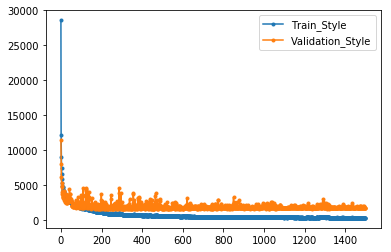

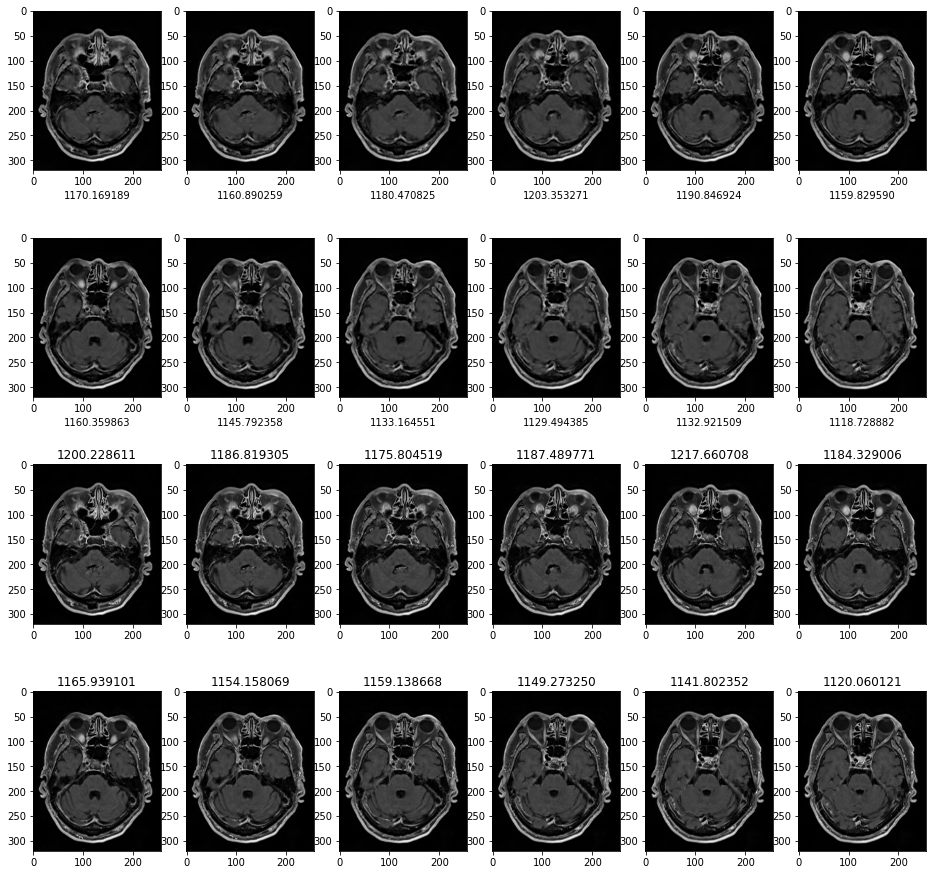

1500/1500 [==============================] - 113076s 75s/step - G_Style: 792.2385 - G_Dis: 1.2022 - D_Dis: 0.0025


In [8]:
epochs = 1500
train_loss = {"Generator_Total" : [], "Generator_Style" : [], "Generator_AD" : [], "Discriminator_AD" : []}
val_loss = {"Generator_Total" : [], "Generator_Style" : [], "Generator_AD" : []}

total_progbar = Progbar(epochs)
A.save("./checkpoint/case3/dense/model.h5")
for epoch in range(epochs):
    #print("Epochs : %03d/%03d"%(epoch+1, epochs))
    epoch_progbar = Progbar(steps)
    epoch_t_g_total = 0
    epoch_t_g_style = 0
    epoch_t_g_dis = 0
    epoch_t_d_dis = 0
    
    epoch_v_g_total = 0
    epoch_v_g_style = 0
    epoch_v_g_dis = 0
    
    for step in range(steps):
        
        idx = step*batch
        
        if step+1 == steps:
            step_train_low = train_low[-batch:]
            step_train_high = train_high[-batch:]
        else:
            step_train_low = train_low[idx:idx+batch]
            step_train_high = train_high[idx:idx+batch]
            
        train_gen_label = np.ones([len(step_train_low), 1], dtype='float')
        train_dis_label = np.zeros([len(step_train_low)*2, 1])
        train_dis_label[len(step_train_low):] = 1.
        
        D.trainable=False
        
        G_Loss = A.train_on_batch(step_train_low, [step_train_high, train_gen_label])
        G_output, _= A.predict(step_train_low)
        
        D.trainable=True
        train_dis_input = np.concatenate([step_train_high, G_output], 0)
        D_Loss = D.train_on_batch(train_dis_input, train_dis_label)
        
        epoch_t_g_total += G_Loss[0]
        epoch_t_g_style += G_Loss[1]
        epoch_t_g_dis += G_Loss[2]
        epoch_t_d_dis += D_Loss
        
        #epoch_progbar.update(step+1, [("G_Style", G_Loss[1]), ("G_Dis", G_Loss[2]), ("D_Dis", D_Loss)])
    
    
    train_loss["Generator_Total"].append(epoch_t_g_total/steps)
    train_loss["Generator_Style"].append(epoch_t_g_style/steps)
    train_loss["Generator_AD"].append(epoch_t_g_dis/steps)
    train_loss["Discriminator_AD"].append(epoch_t_d_dis/steps)
    
    V_loss = A.test_on_batch(val_low, [val_high, np.ones([len(val_low), 1], dtype='float')])

#     epoch_v_g_total += V_loss[0]
#     epoch_v_g_style += V_loss[1]
#     epoch_v_g_dis += V_loss[2]    
#     val_loss["Generator_Total"].append(epoch_v_g_total/steps)
#     val_loss["Generator_Style"].append(epoch_v_g_style/steps)
#     val_loss["Generator_AD"].append(epoch_v_g_dis/steps)
    val_loss["Generator_Total"].append(V_loss[0])
    val_loss["Generator_Style"].append(V_loss[1])
    val_loss["Generator_AD"].append(V_loss[2])
    
    clear_output(wait=True)
    plt.plot(train_loss['Generator_Style'], '.-')
    plt.plot(val_loss['Generator_Style'], '.-')
    plt.legend(['Train_Style', 'Validation_Style'], loc=0)
    plt.show()

    ran_idx = np.random.choice(len(train_low)-1, 1)
    test_in = train_low[ran_idx[0]:ran_idx[0]+1]
    test, _ = A.predict(test_in)
    plot_fn(test, train_high[ran_idx[0]:ran_idx[0]+1])
    
    
    total_progbar.update(epoch+1, [("G_Style", epoch_t_g_style/steps), ("G_Dis", epoch_t_g_dis/steps), ("D_Dis", epoch_t_d_dis/steps)])
    
    if (epoch+1)%100 == 0:
        A.save_weights('./checkpoint/case3/dense/%04d_%.2f_%.2f.h5'%(epoch+1, epoch_t_g_style/steps, V_loss[1]))
        